In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model as lm
import matplotlib.pyplot as plt

# Abstract
As global climate change accelerates, one of the most urgent tasks for the coming decades is to develop accurate predictions about biological responses to guide the effective protection of biodiversity. Biodiversity is defined as “the variety of living species on Earth, including plants, animals, bacteria, and fungi”, scientist has also estimated that there are over 8.1 million species, yet only 1.2 million are discovered, leaving a huge amount of unidentified species. All of the Earth’s species work together to survive and maintain their ecosystems. While researchers are continuously documenting new species and their behavior, prediction models will be decisive in determining the evolution of the biodiversity and saving species before their extinction.


# Introduction
With rising sea levels, pollution, human population growth, increasing consumption and reduced resource efficiency, little is known about how this affects the Earth’s magnificent and complex biodiversity. We wanted to delve deeper into the relationship between environmental changes and biodiversity, seeking to understand the larger scale consequences. In the experiments we have gathered our data from, environmental changes were quantified into increasing nitrogen deposition, increasing atmospheric CO2, and decreasing biodiversity. These three aspects were chosen based on their importance to plant growth and development as CO2 is part of photosynthesis; nitrogen is a key nutrient for plant growth; and data shows that there is a decreasing trend in biodiversity.  

According to NASA, the CO2 concentration has risen from pre-industrial levels of approximately 280 parts per million (ppm) to 420 ppm as of May 2022. This is the highest level ever recorded and NASAs predictions indicate levels up to 1500 ppm over the next few centuries. The amount of nitrogen moving through terrestrial ecosystems has also increased in the recent past. While natural "background" levels of nitrogen fixation have remained constant, human additions to the system through fertilizer production and fossil fuel use have increased dramatically. While nitrogen is a key nutrient for plant growth and plays a critical role in plant community structure, CO2 is the raw material for photosynthesis and is known to affect plant growth and development. Therefore, we found it both logical and interesting to look further into the relationship between nitrogen, carbon dioxide and biodiversity. While the BioCON research experiment at The University of Minnesota (explained in more depth later) focused on how different plant diversities responded to staged  environmental changes. We wanted to look at it from a different perspective, investigating how the soil is affected by different levels of biodiversity. This led us to our research question;

**"Can we build a model to predict the soil levels of nitrogen and carbon dioxide, based on the different levels of biodiversity?"**

Building an understanding of how soil, plants, carbon dioxide and nitrogen interact will be a decisive factor in the fight against climate change. Sustaining biodiversity is important for minimizing the human impact from an ethical point of view, but if the diversity is contributing to sink the climate change, this is an additional incentive to protect and encourage biodiversity.

# Data sampling and collection

We explored several datasets in order to answer our research question regarding how the climate change has an impact on the biodiversity. During the exploratory data analysis, we made several hypotheses based on datasets provided and additional datasets. Some of the hypotheses were discarded because they did not produce the results we expected in order to see relevant relationships between features that could be used in our final machine learning model. Therefore, some of the datasets used in the exploratory data analysis (EDA) will not be used in the modeling to answer the research question.

In [2]:
biocon = pd.read_csv('datasets/bioCON_plant_diversity.txt', delimiter='\t')
species = pd.read_csv('datasets/species.txt', delimiter='\t')
poll = pd.read_csv('datasets/plant_pollinator_diversity_set2.csv')

### The BIOCON experiment
The BIOCON dataset comes from an ecological experiment at the University of Minnesota's Cedar Creek Ecosystem Science Reserve.
Starting in 1997, the goal of this experiment was to explore how different plant communities responded to three environmental changes across the globe. The environmental changes were quantified into increasing nitrogen deposition, increasing atmospheric CO2, and decreasing biodiversity. These three aspects were chosen based on their importance to plant growth and development as CO2 is part of photosynthesis; nitrogen is a key nutritiant for plant growth; and data shows that there is a decreasing trend in biodiversity.

The experiment consisted of 371 2x2-meter plots divided into 6 rings, where some plots was exposed to a carbon dioxide, nitrogen, water or temperature treatment, as well as a different count of species. In 2002, 2007, 2012 and 2016, the level of carbon dioxide and nitrogen in the soil at four depths in each of these plots were measured and logged in the dataset. This is the granularity of the dataset.

While a lot of research already have been done on these topics, several questions remain unanswered. The BIOCON experiment aims to address how these issues affect each other, and which consequences might arise when systems are exposed to these at the same time.

A complementary dataset containing information on which plant species were planted in the different plots was also used in the analysis. This data already contained one-hot encoded values, which made it easier to perform our analysis as we did not have to perform any manipulation on it.

#### Bias
The temperature treatment was based on an assumption of how the trend in increasing temperature will be the next decade in central America. Therefore, this might not represent the true values in the future, thus giving a bias in the fitting of the model.

In the years between 2002 and 2012, all plots in each ring was burned approximetly every other spring. Since 2013, they performed yearly burning in the fall. Therefore, the model has not been trained on plants and communities which has been growing longer than this.

As the experiment performed weeding of the plots by hand, this introduce some bias, as the weeding process might be different on the amount of plots included. The roots of the extracted plants, might also not completely be gone, which also contributed to the bias.

### The impact of Lupinus transgenerational effects
The Lupinus Transgenerational Effects dataset comes from the study conducted by the University of Minnesota's Cedar Creek Ecosystem Science Reserve. Each row represents data related to a lupinus plant from 2006, including information about the maternal plant, offspring, leaflet length in July versus August, root length in August and aboveground biomass. 

# Data cleaning

The BIOCON dataset contained values encoded in different formats and data types. Therefore, a data cleaning process was required in order for us to perform the analysis. The dataset contained some records which were incomplete and had some attributes that lacked values or were invalid. As we wanted to look at the soil percentage of carbon and nitrogen, we dropped the records which had invalid values in these columns

In [3]:
biocon.head()

,Year,Plot,Ring,CO2 Treatment,Nitrogen Treatment,CountOfSpecies,CountOfGroup,Experiment,monospecies,Monogroup,Water Treatment,Temp Treatment,Depth,Carbon(%),Nitrogen(%),C/N Ratio
0,2002,1,1,Cenrich,Namb,4,2,M,,,,,0-10,0.618,0.074,8.351351351
1,2002,1,1,Cenrich,Namb,4,2,M,,,,,10-20,0.515,0.057,9.035087719
2,2002,1,1,Cenrich,Namb,4,2,M,,,,,20-40,0.142,0.023,6.173913043
3,2002,1,1,Cenrich,Namb,4,2,M,,,,,40-60,0.132,0.016,8.25
4,2002,2,1,Cenrich,Namb,1,1,M,Bouteloua gracilis,C-4,,,0-10,0.55,0.07,7.857142857


In [4]:
biocon.dtypes

Year                   int64
Plot                   int64
Ring                  object
CO2 Treatment         object
Nitrogen Treatment    object
CountOfSpecies         int64
CountOfGroup           int64
Experiment            object
monospecies           object
Monogroup             object
Water Treatment       object
Temp Treatment        object
Depth                 object
Carbon(%)             object
Nitrogen(%)           object
C/N Ratio             object
dtype: object

In [5]:
biocon['monospecies'].unique()

array([' ', 'Bouteloua gracilis', 'Asclepias tuberosa',
       'Schizachyrium scoparium', 'Amorpha canescens', 'Bromus inermis',
       'Agropyron repens', 'Lespedeza capitata', 'Petalostemum villosum',
       'Poa pratensis', 'Solidago rigida', 'Anemone cylindrica',
       'Koeleria cristata', 'Achillea millefolium', 'Lupinus perennis',
       'Andropogon gerardi', 'Sorghastrum nutans'], dtype=object)

The unvalid values are replaced to a standardized value so we easily can manipulate them at the same. The numerical values are parsed to fulfill the requirements from regression analysis.

In [6]:
biocon['Carbon(%)'].replace('', np.nan, inplace=True)
biocon['Nitrogen(%)'].replace('', np.nan, inplace=True)
biocon['C/N Ratio'].replace(' ', np.nan, inplace=True)
biocon.dropna(subset=['Carbon(%)', 'Nitrogen(%)', 'C/N Ratio'], inplace=True)
biocon['Carbon(%)'] = biocon['Carbon(%)'].astype(float)
biocon['Nitrogen(%)'] = biocon['Nitrogen(%)'].astype(float)
biocon['C/N Ratio'] = biocon['C/N Ratio'].astype(float)

### Remove outliers
In order to not remove any more records than necessary, we wanted to make a visualization of the different soil levels due to the percentage values being dependent on the depth. As shown in the figure below, the soil levels of carbon and nitrogen decrease with depth. We can also see from the visualization that most of the distributions are right skewed with long right tails. In the first figure visualizing the carbon distribution, we can clearly see that the different depths have different thresholds for values we would mark as outliers. Observations more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are marked as outliers. In the first figure below, the threshold of the higher values are highlighted with vertical lines with the corresponding colors.

In [7]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[(data[variable] >= lower) & (data[variable] <= upper)]

#### Outliers in the carbon values

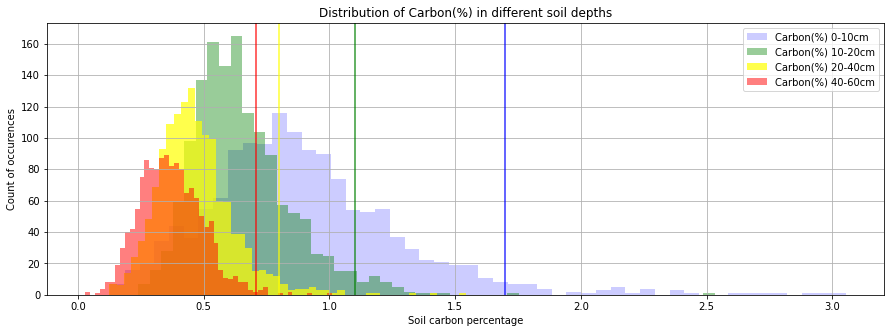

In [8]:
biocon[biocon['Depth'] == '0-10']['Carbon(%)'].hist(bins=50, figsize=(15,5), alpha=0.2, color='blue')
biocon[biocon['Depth'] == '10-20']['Carbon(%)'].hist(bins=50, figsize=(15,5), alpha=0.4, color='green')
biocon[biocon['Depth'] == '20-40']['Carbon(%)'].hist(bins=50, figsize=(15,5), alpha=0.7, color='yellow')
biocon[biocon['Depth'] == '40-60']['Carbon(%)'].hist(bins=50, figsize=(15,5), alpha=0.5, color='red')
plt.xlabel('Soil carbon percentage')
plt.ylabel('Count of occurences')
plt.title('Distribution of Carbon(%) in different soil depths')
plt.legend(['Carbon(%) 0-10cm','Carbon(%) 10-20cm','Carbon(%) 20-40cm','Carbon(%) 40-60cm'])

# The threshold values calculated in the cell below
plt.axvline(1.7, color='blue', alpha=0.8)
plt.axvline(1.1, color='green', alpha=0.8)
plt.axvline(0.8, color='yellow', alpha=0.8)
plt.axvline(0.71, color='red', alpha=0.8)

In [9]:
# Observations more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are marked as outliers.
for depth in ['0-10','10-20','20-40','40-60']:
    df = biocon[biocon['Depth'] == depth]
    column = 'Carbon(%)'
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    low = (Q1 - 1.5 * IQR)
    high = (Q3 + 1.5 * IQR)
    
    print(depth)
    print('Low:', low)
    print('High:', high)
    #filtered_index = df[((df[column] <= low) or (df[column] >= high))].index
    #biocon.drop(biocon[df[column] >= high].index, inplace=True)
    # Remove Outliers
    
ten = remove_outliers(biocon[biocon['Depth'] == '0-10'], 'Carbon(%)', -0.003125, 1.73787)
twenty = remove_outliers(biocon[biocon['Depth'] == '10-20'], 'Carbon(%)', 0.16775, 1.10575)
fourty = remove_outliers(biocon[biocon['Depth'] == '20-40'], 'Carbon(%)', 0.1137499, 0.79575)
sixty = remove_outliers(biocon[biocon['Depth'] == '40-60'], 'Carbon(%)', 0.02200, 0.71)

biocon = pd.concat([ten, twenty, fourty, sixty])

0-10
Low: -0.0031249999999998224
High: 1.7378749999999998
10-20
Low: 0.16775000000000018
High: 1.10575
20-40
Low: 0.11374999999999996
High: 0.7957500000000001
40-60
Low: 0.02200000000000002
High: 0.71


#### Outliers in the nitrogen values

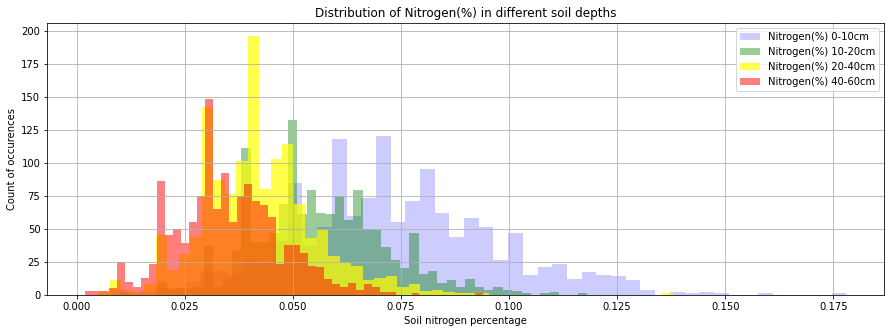

In [10]:
biocon[biocon['Depth'] == '0-10']['Nitrogen(%)'].hist(bins=50, figsize=(15,5), alpha=0.2, color='blue')
biocon[biocon['Depth'] == '10-20']['Nitrogen(%)'].hist(bins=50, figsize=(15,5), alpha=0.4, color='green')
biocon[biocon['Depth'] == '20-40']['Nitrogen(%)'].hist(bins=50, figsize=(15,5), alpha=0.7, color='yellow')
biocon[biocon['Depth'] == '40-60']['Nitrogen(%)'].hist(bins=50, figsize=(15,5), alpha=0.5, color='red')
plt.xlabel('Soil nitrogen percentage')
plt.ylabel('Count of occurences')
plt.title('Distribution of Nitrogen(%) in different soil depths')
plt.legend(['Nitrogen(%) 0-10cm','Nitrogen(%) 10-20cm','Nitrogen(%) 20-40cm','Nitrogen(%) 40-60cm'])

In [11]:
for depth in ['0-10','10-20','20-40','40-60']:
    df = biocon[biocon['Depth'] == depth]
    column = 'Nitrogen(%)'
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    low = (Q1 - 1.5 * IQR)
    high = (Q3 + 1.5 * IQR)
    
    print(depth)
    print('Low:', low)
    print('High:', high)
    #filtered_index = df[((df[column] <= low) or (df[column] >= high))].index
    #biocon.drop(biocon[df[column] >= high].index, inplace=True)
    # Remove Outliers
    
tenN = remove_outliers(biocon[biocon['Depth'] == '0-10'], 'Nitrogen(%)', 0.01425, 0.13225)
twentyN = remove_outliers(biocon[biocon['Depth'] == '10-20'], 'Nitrogen(%)', 0.0159, 0.096)
fourtyN = remove_outliers(biocon[biocon['Depth'] == '20-40'], 'Nitrogen(%)', 0.0075, 0.0755)
sixtyN = remove_outliers(biocon[biocon['Depth'] == '40-60'], 'Nitrogen(%)', 0.03, 0.067)

biocon = pd.concat([tenN, twentyN, fourtyN, sixtyN])

0-10
Low: 0.01425000000000002
High: 0.13224999999999998
10-20
Low: 0.015999999999999993
High: 0.096
20-40
Low: 0.0075
High: 0.07550000000000001
40-60
Low: 0.003000000000000006
High: 0.06699999999999999


From the distribution, we can see that certain values dominate the distribution creating remarkable gaps. This is probably due to some measurements being rounded to the same values in the experiment. Therefore, this is not something that we will be further concerned about in our analysis. Below we can see the top 5 nitrogen percentage values.

In [12]:
biocon[biocon['Depth'] == '40-60']['Nitrogen(%)'].value_counts().head()

0.030    107
0.040     56
0.034     45
0.035     38
0.036     37
Name: Nitrogen(%), dtype: int64

# Exploratory data analysis

To answer this, we will use different tools and methods to see if we can find some inference in the data we collected.
With Exploration, we will use visualizations and descriptive statistics to make some predictions on the data by using machine learning and fitting a regression model, optimization it to the data we have collected based on our thoughts and ideas obtained from earlier exploration.

### Lupinus Transgenerational Effects
A big part of our EDA, which ended up not being relevant for our final machine learning model, was to see if one specific species in the research study, specifically the lupinus, had an impact on biodiversity. <br />

According to WWF, invasive species and disease is the third biggest threat to biodiversity, and constitutes 13% of the recorded threats to biodiversity on average. Lupinus is considered to be such a species. Its quick growth and length tend to shade for shorter species and outcompete them. The lupinus also produces alkaloid compounds that are said to have a negative impact on the germination of seeds from other species.
When investigating the Lupinus Transgenerational Effects dataset from the Cedar Creek research study, we found a clear relationship between the carbon dioxide treatment on the offspring and the leaflet length in August. A similar relationship was found between the carbon dioxide treatment on the offspring and aboveground biomass. The results show that elevated carbon dioxide treatment has a positive effect on the lupinus.


In [13]:
lupinus = pd.read_csv('datasets/e141_Lupinus Transgenerational Effects.txt', delimiter='\t')

In [14]:
test = lupinus.groupby(['Maternal plot', 'Offspring CO2']).mean('aboveground biomass (g)').sort_values(['aboveground biomass (g)'])['aboveground biomass (g)'].to_frame().reset_index()
test.head()

test1 = lupinus.groupby(['Maternal plot', 'Offspring CO2']).mean('August leaflet length').sort_values(['August leaflet length'])['August leaflet length'].dropna().to_frame().reset_index()
test1.head()

,Maternal plot,Offspring CO2,August leaflet length
0,184.0,elevated,18.000000
1,205.0,ambient,19.666667
2,275.0,elevated,20.000000
3,354.0,ambient,20.000000
4,175.0,ambient,20.000000


<AxesSubplot:ylabel='aboveground biomass (g)'>

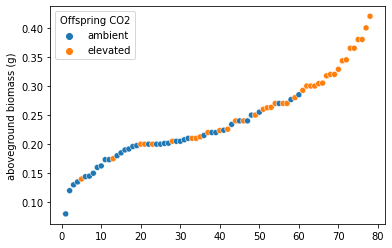

In [15]:
x_axis=[*range(1,84,1)]
sns.scatterplot(data=test, x=x_axis, y='aboveground biomass (g)', hue='Offspring CO2')

<AxesSubplot:ylabel='August leaflet length'>

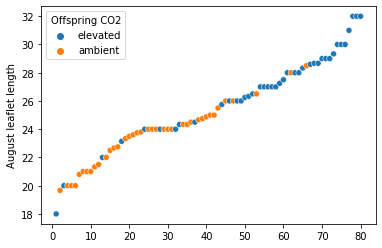

In [16]:
x_axis=[*range(1,81,1)]
sns.scatterplot(data=test1, x=x_axis, y='August leaflet length', hue='Offspring CO2')

In [17]:
lup = poll[poll['PLTSP_NAME']=='Lupinus laxiflorus']
lup.shape

(867, 16)

In [18]:
lup = lup.groupby('PLOT_ID').size().to_frame().reset_index().rename(columns={0:'Lupinus'})
lup.shape
lup.head()

,PLOT_ID,Lupinus
0,BGD01,1
1,BGD02,1
2,BGD03,4
3,BGD04,2
4,BGD05,2


In [19]:
other_species = poll[poll['PLTSP_CODE']!='LUPILAXI']
other_species.shape

(21752, 16)

In [20]:
other_species = other_species.groupby('PLOT_ID').size().to_frame().reset_index().rename(columns={0:'Other'})
other_species.shape
other_species.head()

,PLOT_ID,Other
0,BGD01,37
1,BGD02,27
2,BGD03,40
3,BGD04,34
4,BGD05,38


In [21]:
pollinator = pd.merge(lup, other_species, on='PLOT_ID').sort_values('Lupinus')
pollinator.head()

,PLOT_ID,Lupinus,Other
0,BGD01,1,37
33,CNT01,1,35
36,CNT05,1,52
40,CPB05,1,199
42,CPB07,1,201


<AxesSubplot:xlabel='Lupinus', ylabel='Other'>

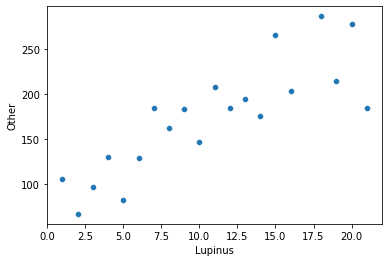

In [22]:
mean_lupinus = pollinator.groupby('Lupinus').mean()
mean_lupinus
sns.scatterplot(data=mean_lupinus, x='Lupinus', y='Other')

From the results showing that lupinus thrived with increasing carbon dioxide levels, and an increasing share of lupinus plants has a negative effect on the share of other plant species, we made the hypothesis: The more lupinus plants in a plot, the fewer other plant species will exist in the plot.

In order to test the hypothesis, we used the plant pollinator diversity set 2 in order to find the relationship between the number of lupinus plants versus other plant species in an area. Because it was considerable larger amount of values for the number of other species than the number of lupinus plants, we looked at the mean of the number of other species. 

The results from the plot shows the opposite of what we expected from our hypothesis: The number of other plant species increases when the number of lupinus plants increases in an area. Therefore, we decided not to include the number of lupinus plants from the plots in the BIOCON study as a feature in our model.

### The count of plant species has effect on the Carbon levels in the soil
As we wanted to see how biodiversity contributed to the soil levels of carbon and nitrogen, we wanted to see if these values were affected by the count of species in the different plots. The experiment contained 6 rings with a total of  371 plots, in which each plot within a ring was isolated from each other. The plots contained different counts of species where some of the plots had individual water or temperature treatments, or enriched levels of nitrogen and CO2. Some of the plots had zero species planted, and others were monospecies plots.
We plotted the depths separated from each other as we earlier have shown that the soil levels are different based on the depths. From the figure we can see that the nitrogen percentage in the soil increases with the count of species. The visualization of the carbon percentage can be found in the attached notebook, but the graphs look similar to the visualization of the nitrogen levels.

Text(0.5, 1.0, 'The average Carbon level for each count of species')

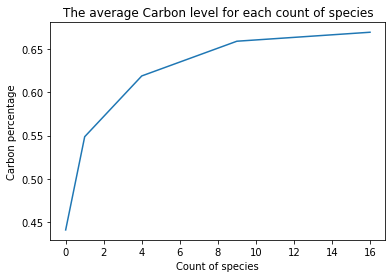

In [23]:
biocon.groupby(['CountOfSpecies'])['Carbon(%)'].mean().plot()
plt.ylabel('Carbon percentage')
plt.xlabel('Count of species')
plt.title('The average Carbon level for each count of species')

Text(0.5, 1.0, 'The average Nitrogen level for each count of species')

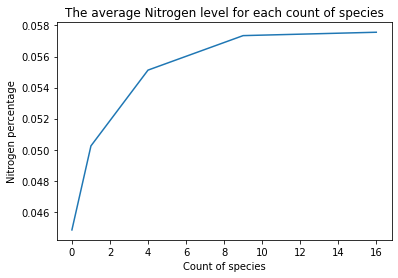

In [24]:
biocon.groupby(['CountOfSpecies'])['Nitrogen(%)'].mean().plot()
plt.ylabel('Nitrogen percentage')
plt.xlabel('Count of species')
plt.title('The average Nitrogen level for each count of species')

In [25]:
biocon[(biocon['Temp Treatment'] == 'HTelv') | (biocon['Temp Treatment'] == 'HTamb')]['Carbon(%)'].mean()

0.6713151862464184

### Nitrogen percentage based on count of species and depth


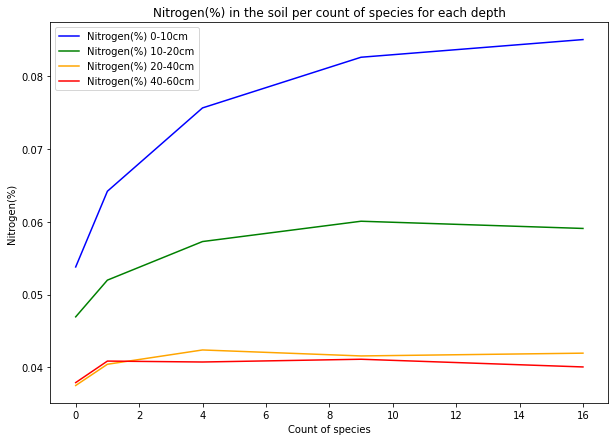

In [26]:
df = biocon.loc[:, ['CountOfSpecies', 'Depth', 'Nitrogen(%)', 'Nitrogen Treatment']].copy()

df['Nitrogen(%)'] = pd.to_numeric(df['Nitrogen(%)'], errors='coerce')
df['CountOfSpecies'] = pd.to_numeric(df['CountOfSpecies'], errors='coerce')

#fig, axes = plt.subplots(nrows=2, ncols=2)

ax = df[(df['Depth'] == '0-10')].groupby('CountOfSpecies').mean().plot(color='blue', figsize=(10,7))
df[(df['Depth'] == '10-20')].groupby('CountOfSpecies').mean().plot(ax=ax, color='green')
df[(df['Depth'] == '20-40')].groupby('CountOfSpecies').mean().plot(ax=ax, color='orange')
df[(df['Depth'] == '40-60')].groupby('CountOfSpecies').mean().plot(ax=ax, color='red')

plt.xlabel('Count of species')
plt.ylabel('Nitrogen(%)')
plt.title('Nitrogen(%) in the soil per count of species for each depth')
plt.legend(['Nitrogen(%) 0-10cm','Nitrogen(%) 10-20cm','Nitrogen(%) 20-40cm','Nitrogen(%) 40-60cm'])

Text(0.5, 1.0, 'Carbon levels')

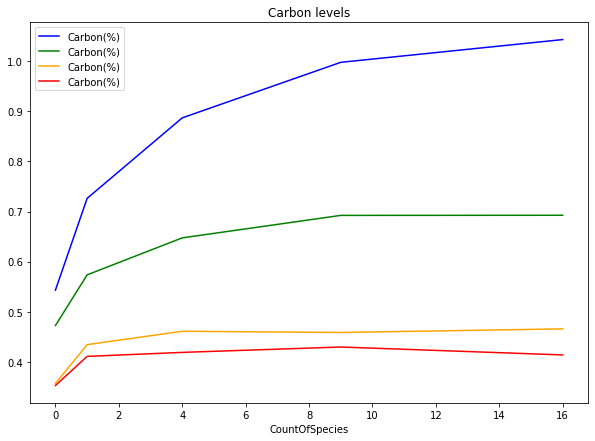

In [27]:
df = biocon.loc[:, ['CountOfSpecies', 'Depth', 'Carbon(%)']].copy()

df['Carbon(%)'] = pd.to_numeric(df['Carbon(%)'], errors='coerce')
df['CountOfSpecies'] = pd.to_numeric(df['CountOfSpecies'], errors='coerce')

#fig, axes = plt.subplots(nrows=2, ncols=2)

ax = df[(df['Depth'] == '0-10')].groupby('CountOfSpecies').mean().plot(color='blue', figsize=(10,7))
df[(df['Depth'] == '10-20')].groupby('CountOfSpecies').mean().plot(ax=ax, color='green')
df[(df['Depth'] == '20-40')].groupby('CountOfSpecies').mean().plot(ax=ax, color='orange')
df[(df['Depth'] == '40-60')].groupby('CountOfSpecies').mean().plot(ax=ax, color='red')
plt.title('Carbon levels')

From the plot above, we can see that the deeper values have lower values of nitrogen.

We can also see that the slope is similar in the different depths, but the scaling is different

In [28]:
biocon.groupby('Year').mean()

,Plot,CountOfSpecies,CountOfGroup,Carbon(%),Nitrogen(%),C/N Ratio
Year,,,,,,
2002,184.295797,5.242665,2.279937,0.543568,0.055761,9.720986
2007,189.203456,5.018068,2.226237,0.650644,0.057122,11.192095
2012,188.492611,5.197044,2.278677,0.620255,0.054683,11.223270
2016,189.305859,5.623635,2.458788,0.589565,0.045836,13.105759


### The impact of nitrogen and CO2 treatment
The plots that received nitrogen treatment, was treated with 34% ammonium nitrate pellets three times per growing season and also 15N enrichement at the time of fertilization three times per growing season. Three of the six rings got CO2 enriched air with a CO2 concentration of 560 ppm, while the ambient level was 368 ppm. This treatment was done using Free Air CO2 Encrichement (FACE) technology.

We wanted to see how these treatments impacted the soil levels of nitrogen and carbon.

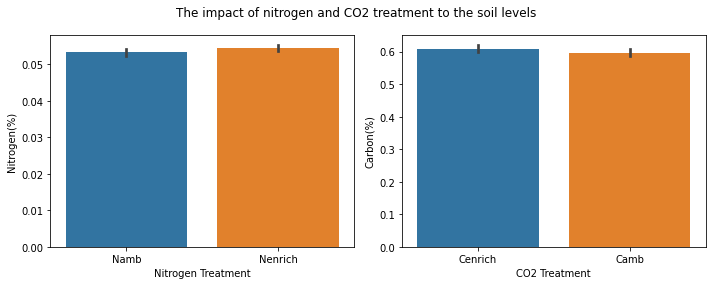

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
#biocon.loc[:,['Nitrogen Treatment', 'Nitrogen(%)']].plot(..., ax=ax1)
sns.barplot(data = biocon, x="Nitrogen Treatment", y='Nitrogen(%)', ax=ax1)
sns.barplot(data = biocon, x="CO2 Treatment", y='Carbon(%)', ax=ax2)
plt.suptitle('The impact of nitrogen and CO2 treatment to the soil levels')
plt.tight_layout()

As the figure above shows, the impact of the treatments does give a slight difference in the soil levels, but these were not significant. We initially thought this treatment would have a more severe consequence than what we found in our analysis.

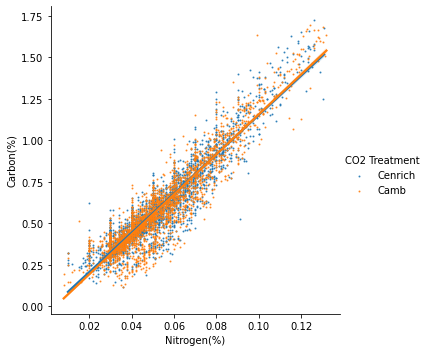

In [30]:
sns.lmplot(x = "Nitrogen(%)", y = "Carbon(%)", data = biocon, hue = "CO2 Treatment", scatter_kws={"s": 1})

In [31]:
biocon.groupby(['Ring'])['Carbon(%)', 'Nitrogen(%)', 'CountOfSpecies'].mean()

/var/folders/jr/90trlx1148g4hs4p4rs_y01m0000gn/T/ipykernel_15772/4173151406.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  biocon.groupby(['Ring'])['Carbon(%)', 'Nitrogen(%)', 'CountOfSpecies'].mean()


,Carbon(%),Nitrogen(%),CountOfSpecies
Ring,,,
,0.590000,0.040000,1.000000
1,0.552559,0.050253,5.287433
2,0.525111,0.047015,5.396273
3,0.655507,0.058390,5.172338
4,0.612994,0.055072,5.259346
5,0.607648,0.052645,5.286802
6,0.646482,0.058146,5.119578


**Temperature Treatment**

In the BioCON research experiment, 48 of the plots in the study recieved a temperature treatment of 2 deegrees C meant to represent the minimum warming predicted the next century for Central North America. Therefore, we wanted to check if this treatment had any correlation with the amount of Carbon and Nitrogen in the soil for each plot. All of the 48 plots which recieved the treatment all had the diversity of 9 different species. In order to see if the treatment had any significant effect, we compared the overall mean for the plots affected by temperature treatment with the plot not affected, and found little reason to belive this has a impact.

In [32]:
biocon[biocon['CountOfSpecies'] == 9].groupby('Temp Treatment')['Carbon(%)', 'Nitrogen(%)'].mean()

/var/folders/jr/90trlx1148g4hs4p4rs_y01m0000gn/T/ipykernel_15772/2545590124.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  biocon[biocon['CountOfSpecies'] == 9].groupby('Temp Treatment')['Carbon(%)', 'Nitrogen(%)'].mean()


,Carbon(%),Nitrogen(%)
Temp Treatment,,
,0.650152,0.059002
HTamb,0.679295,0.055624
HTelv,0.663472,0.054381


In [33]:
biocon.groupby('Year')['Carbon(%)', 'Nitrogen(%)'].mean()

/var/folders/jr/90trlx1148g4hs4p4rs_y01m0000gn/T/ipykernel_15772/2658047545.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  biocon.groupby('Year')['Carbon(%)', 'Nitrogen(%)'].mean()


,Carbon(%),Nitrogen(%)
Year,,
2002,0.543568,0.055761
2007,0.650644,0.057122
2012,0.620255,0.054683
2016,0.589565,0.045836


### Feature Engineering
The experiments described above gave us the foundations to confidently select which features we wanted to include in our prediction model. We chose to use the count of species, the different depths, and the one-hot encoded information of which species were included in the different plots to predict the levels of nitrogen and carbon in the soil. While dropping the treatment features, plot, ring, monogroup, monospecies, count of group, experiment as these would not increase the accuracy of the model. We also chose to drop the year attribute, as we wanted to be able to predict future values which would contain years not fitted in the model.

##### Count of species
As proved in our hypothesis above, this was an obvious choice to include in the fitting of our model.
##### Depth
As the soil levels decrease at greater depths in the soil, this was valuable to include as a feature.
The values were originally encoded as labels depending on which range the samples was collected from, we needed to replace the values in order to fit a regression model. As we had already parsed the numerical values to be able to input into the regression model, and the plot species information was already one-hot encoded when merging. We decided to integer-encode the depth values, as these were categorical variables from before. We discussed the alternative encoding of choosing the average depth of the categorical ranges, but decided that we did not need a continuous variable.
##### Species
As we wanted to build a model to predict the soil levels of nitrogen and carbon based on the biodiversity, we wanted to include which species were included in the plots. The experiment had available data which were already one hot encoded, meaning that each plant species had a binary (0-1) number indicating if it was present in the plot or not, indexed by the plot. This dataset was merged with the BIOCON dataset before training the regression model, expanding and replacing the purpose of the original monospecies and monogroup column. It was easily available, and there is no ordinal relationship which is why an integer encoding would not be sufficient.

##### Features not included

Features like index, plot, etc. does not have an impact of the soil levels and are only present as labeling. Therefore, these were removed from the dataset before the fitting of the model. As shown earlier in the analysis, the visualization indicate that there were no big difference between the different treatments and the carbon/nitrogen percent in the soil. We did not use "Year" as a feature because we would presumably want to use this model to predict values with data in later years, which would then contain "Year" values not used in the fitting of the model.

In [34]:
total = pd.merge(biocon, species, on='Plot')
total = total.drop(columns = ['Ring_x','CO2 Treatment', 'Nitrogen Treatment', 'Experiment', 'monospecies',
                              'Monogroup', 'Water Treatment', 'Temp Treatment', 'CountOfGroup', 'Ring_y', 'C/N Ratio', 'Year'])
total['Depth'].replace(['0-10','10-20','20-40', '40-60'], [0,1,2,3], inplace=True)
total

,Plot,CountOfSpecies,Depth,Carbon(%),Nitrogen(%),Achillea millefolium,Agropyron repens,Amorpha canescens,Andropogon gerardi,Anemone cylindrica,...,Bouteloua gracilis,Bromus inermis,Koeleria cristata,Lespedeza capitata,Lupinus perennis,Petalostemum villosum,Poa pratensis,Schizachyrium scoparium,Solidago rigida,Sorghastrum nutans
0,1,4,0,0.6180,0.074,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,1,4,0,1.0000,0.077,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,1,4,0,1.0120,0.086,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,1,4,0,0.8600,0.060,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,1,4,1,0.5150,0.057,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4957,343,1,2,0.5040,0.042,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4958,343,1,2,0.5240,0.047,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4959,343,1,2,0.4510,0.036,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4960,343,1,3,0.3389,0.049,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
total.dtypes

Plot                         int64
CountOfSpecies               int64
Depth                        int64
Carbon(%)                  float64
Nitrogen(%)                float64
Achillea millefolium         int64
Agropyron repens             int64
Amorpha canescens            int64
Andropogon gerardi           int64
Anemone cylindrica           int64
Asclepias tuberosa           int64
Bouteloua gracilis           int64
Bromus inermis               int64
Koeleria cristata            int64
Lespedeza capitata           int64
Lupinus perennis             int64
Petalostemum villosum        int64
Poa pratensis                int64
Schizachyrium scoparium      int64
Solidago rigida              int64
Sorghastrum nutans           int64
dtype: object

# Data modeling and inferences

We used a linear regression model with cross validation, splitting the dataset into 80% training data and keeping 20% as a validation set. The dataset was shuffled before the split, so the sampling would be random to not give an ordering error in the fitting and testing. To measure the performance of the model, we used the RMSE (Root Mean Squared Error) metric. RMSE is known to be less robust to outliers as it gives higher weights to large errors. It is a very common metric when evaluating regression models as it is a good general purpose error metric.

In [ ]:
biocon.head()

,Year,Plot,Ring,CO2 Treatment,Nitrogen Treatment,CountOfSpecies,CountOfGroup,Experiment,monospecies,Monogroup,Water Treatment,Temp Treatment,Depth,Carbon(%),Nitrogen(%),C/N Ratio
0,2002,1,1,Cenrich,Namb,4,2,M,,,,,0-10,0.618,0.074,8.351351351
1,2002,1,1,Cenrich,Namb,4,2,M,,,,,10-20,0.515,0.057,9.035087719
2,2002,1,1,Cenrich,Namb,4,2,M,,,,,20-40,0.142,0.023,6.173913043
3,2002,1,1,Cenrich,Namb,4,2,M,,,,,40-60,0.132,0.016,8.25
4,2002,2,1,Cenrich,Namb,1,1,M,Bouteloua gracilis,C-4,,,0-10,0.55,0.07,7.857142857


Write something more about the training process etc.

### Cross validation
We separated the dataset into a training set and validation/ test set. The split was done in 80% training and the rest as the validation.


In [53]:
np.random.seed(1337)

def train_test_split(data):
    lenght = data.shape[0]
    shuffled_indices = np.random.permutation(lenght)
    
    # Split data into 80% train and 20% test
    train_indices = np.array(shuffled_indices[:int(lenght*0.8)])
    test_indices = np.array(shuffled_indices[int(lenght*0.8):])
    train = data.iloc[train_indices]
    test = data.iloc[test_indices]
    return train, test
    
train, test = train_test_split(total)

Xtrain = train.drop(columns=['Carbon(%)']).to_numpy()
ytrain = train.loc[:, 'Carbon(%)'].to_numpy()

Xtest = test.drop(columns=['Carbon(%)']).to_numpy()
ytest = test.loc[:, 'Carbon(%)'].to_numpy()


linear_model = lm.LinearRegression(fit_intercept=True)
type(ytrain[0])

numpy.float64

In [54]:
# Fit the 1st model
# Compute the fitted and predicted values of Log Sale Price for 1st model
linear_model.fit(Xtrain, ytrain)
y_fitted = linear_model.predict(Xtrain)
y_predicted = linear_model.predict(Xtest)

### Measuring error
To evaluate our model, we used the rmse (Root Mean Squared Error) performance metric.

In [38]:
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

In [55]:
# Training and test errors for the 1st model
training_error_m1 = rmse(y_fitted, ytrain)
test_error_m1 = rmse(y_predicted, ytest)

print("1st Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m1, test_error_m1))

1st Model
Training RMSE: 0.09372001954939153
Test RMSE: 0.09106098589248408



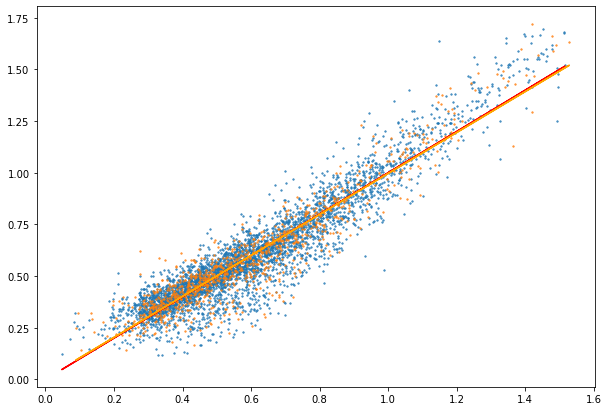

In [56]:
x1, y1 = y_fitted, ytrain
x2, y2 = y_predicted, ytest

plt.figure(figsize=(10,7))
plt.scatter(x1, y1, alpha=0.8, linewidth=0.5, s=3)
plt.scatter(x2, y2, alpha=0.8, linewidth=0.5, s=3)

m1, b1 = np.polyfit(x1, y1, 1)
m2, b2 = np.polyfit(x2, y2, 1)

#add linear regression line to scatterplot 
plt.plot(x1, m1*x1+b1, color='red')
plt.plot(x2, m2*x2+b2, color='orange')

# Discussion 

### Result
Based on the resulting RMSE values, it looks like our model gives an excellent prediction of the validation dataset and it can replicate the data it has not been fitted on quite well. As the values are so low, this might also indicate that there is some sampling bias in our test set, or that the data contains to few values to fit and train the model on. The test cases might be easily predicted by the model and due to the similarity to those values it has been trained on.

In [57]:
display(biocon.shape)
display(train.shape)
display(test.shape)

(4962, 16)

(3969, 21)

(993, 21)

### Bias-variance tradeoff
As the data only contains a few features to include in the model, the model complexity is limited to these. If we were to increase the complexity of the model, we would likely do the EDA in greater depth to see if we could include some other values. The experiment also contains a big amount of extensive datasets which we could explore and merge with the BIOCON dataset and test a new regression model on these features.

### Future improvements
Further research into the topic, maybe there are some other features we need more knowledge of to be able to improve the accuracy of the model?

As the research was performed only in perfect weather conditions, even with the different treatments, an input with these cercumstances would not be guaranteed a accurate prediction.

### Conclusion
Going back to the research question **"Can we build a model to predict the soil levels of nitrogen and carbon dioxide, based on the different levels of biodiversity?"**, we can discuss whether it is a representative quantification of biodiveristy. As the features we included in our model to predict the values were limited to depth of sample, count of species in the plot, and which species were included in the plot, and due to the experiment only containing 16 different plant species.

Based on our selection of the available features, we conclude with a model that is able to predict the carbon and nitrogen percentage in the soil based on sample depth, count of species and types of plant species.

# References
* https://education.nationalgeographic.org/resource/biodiversity
* https://climate.nasa.gov/climate_resources/24/graphic-the-relentless-rise-of-carbon-dioxide/
* https://www.weforum.org/agenda/2020/11/wwf-living-planet-report-2020-biodiversity-threat
* https://magazine.scienceconnected.org/2016/10/lupine-invasions/#:~:text=Lupines%20also%20produce%20a%20wide,biodiversity%20in%20areas%20they%20invade.

DATASET CREDITS: <br />
MS001: Pollinator dataset

Data were provided by the HJ Andrews Experimental Forest research program, funded by the National Science Foundation's Long-Term Ecological Research Program (DEB 2025755), US Forest Service Pacific Northwest Research Station, and Oregon State University.
Daly, C.; Schulze, M.; McKee, W. 2019. Meteorological data from benchmark stations at the HJ Andrews Experimental Forest, 1957 to present. Long-Term Ecological Research. Forest Science Data Bank, Corvallis, OR. [Database]. Available: http://andlter.forestry.oregonstate.edu/data/abstract.aspx?dbcode=MS001. https://doi.org/10.6073/pasta/c021a2ebf1f91adf0ba3b5e53189c84f. Accessed 2022-11-11.